# DS Challenge

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Revisión e inspección visual del set de datos

In [2]:
df = pd.read_csv('dataset_SCL.csv')

/tmp/ipykernel_8966/3467307737.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset_SCL.csv')


Pandas me advierte que las columnas 1 y 6 tienen tipos mixtos. Deberé tener más cuidado en adelante.

In [3]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


Según se puede observar, la mayoría de los datos son de tipo categórico, excepto las fechas que en algunos casos son numéricos y en otros son de tipo datetime.

In [4]:
df.dtypes

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object

Sin embargo, pandas no reconoce automáticamente toda la información, por lo que es necesario formatear. Antes, eso sí, voy a hacer una pequeña inspección visual.

In [5]:
for col in df.columns:
    print(col, '\n', df[col].unique())

Fecha-I 
 ['2017-01-01 23:30:00' '2017-01-02 23:30:00' '2017-01-03 23:30:00' ...
 '2017-12-25 14:55:00' '2017-12-29 14:55:00' '2017-12-31 14:55:00']
Vlo-I 
 ['226' '912' '940' '92' '93' '401' '11' '1011' '1281' '1283' '1285' '1287'
 '1289' '1291' '2291' '98' '116' '176' '240' '295' '689' '250' '112' '118'
 '174' '249' '276' '495' '4495' '146' '7661' '7663' '9245' '9268' '9362'
 '6830' '702' '624' '28' '846' '709' '741' '8021' '8023' '8027' '8029'
 '8069' '8073' '8075' '8099' '8125' '8137' '8160' '8161' '9601' '9615'
 '9651' '9653' '9661' '9689' '9782' '9623' '1' '3' '7' '9' '13' '15' '17'
 '21' '23' '25' '41' '43' '51' '53' '55' '61' '71' '73' '75' '81' '83'
 '102' '104' '106' '108' '110' '120' '122' '128' '130' '132' '134' '140'
 '142' '150' '156' '160' '162' '164' '166' '170' '172' '180' '182' '184'
 '186' '188' '190' '192' '194' '196' '501' '503' '507' '521' '531' '551'
 '800' '802' '804' '1083' '14' '31' '35' '37' '57' '65' '67' '69' '89'
 '91' '97' '114' '124' '126' '136' '138' '1

Normalmente el análisis del set de datos sería un paso previo bastante exigente en un problema completo de predicción. En este caso, debido a las restricciones del desafío, trataré de reducir este paso a lo mínimo necesario sin eliminarlo, pues es muy útil.
Los campos de origen, sea programado u oficialmente operado, no son informativos para los modelos, pues son completamente estáticos. Por ello, se eliminarán ORI-I, ORI-O y SIGLAORI de los datos de predicción.

In [6]:
df.isnull().values.any()

True

Como en muchas ocasiones, también será necesario el manejo de valores nulos.

## Preprocesamiento I

Mi objetivo es hacer inferencia sobre los datos. Para ello quiero contestar las preguntas con esto en mente. En el primer punto del desafío hay dos preguntas: "¿Cómo se distribuyen los datos?" y "¿Qué te llama la atención o cuál es tu conclusión sobre esto?". Si bien la segunda pregunta está apuntando a la distribución de los datos, pueden aparecer cosas interesantes durante el análisis por lo que la tendré cuenta ya desde el preprocesamiento.

### Limpieza

Voy a partir eliminando los campos que considero redundantes. Los campos `Ori-I`, `Ori-O` y `SIGLAORI` solo poseen un valor debido a que este análisis está centrado en el aeropuerto Arturo Merino Benitez. No aportan mucha mayor información, y serán eliminados. Tampoco aportan mucho a la primera pregunta.

In [7]:
df.drop(['Ori-I', 'Ori-O', 'SIGLAORI'], inplace=True, axis=1)

También eliminaré la sigla de destino por considerarla irrelevante para el modelo. Aunque, sí sería de utilidad más tarde cuando hayan predicciones, es por esto que es mejor generar un diccionario que ayude a transformar.
Es seguro asumir que la aerolínea que tiene el código de programación es la que opera el vuelo. En ocasiones es posible pensar que entre aerolíneas se arrienden los aviones, pero la responsabilidad caería sobre quien originalmente preste el servicio. De todas formas hice una inspección visual que corroborase esto, pero no la incluí por cuestión de presentación del cuaderno.

In [8]:
codigos = list(df['Emp-I'].unique())
codigos = sorted(codigos)

aerolineas = {} #Esta conversión no es biyectiva pues el Grupo LATAM tiene varios códigos por lo que solo puede ir en una dirección
for cod in codigos:
    trad = df.loc[df['Emp-I'] == cod]
    if len(trad['OPERA'].unique()) > 1:
        print("Error en suposición")
    aerolineas[cod] = trad['OPERA'].unique()[0]

Como estamos operando con códigos de pasajeros podemos asumir que el estándar de estos códigos es ICAO (que de hecho coincide para Lima en una rápida inspección), y eso corresponde con 4 letras. Por lo tanto el identificador sería único, y podemos mapear de la misma manera, esta vez para la ciudad del aeropuerto de destino (usando la columna programada).

In [9]:
codigos = list(df['Des-I'].unique())
codigos = sorted(codigos)

aeropuertos = {} #Esta conversión no es biyectiva pues el Grupo LATAM tiene varios códigos por lo que solo puede ir en una dirección
for cod in codigos:
    trad = df.loc[df['Des-I'] == cod]
    if len(trad['SIGLADES'].unique()) > 1:
        print("Error en suposición", trad['SIGLADES'].unique())
    aeropuertos[cod] = trad['SIGLADES'].unique()[0]

Error en suposición ['Houston' 'Washington']
Error en suposición ['Nueva York' 'Miami']
Error en suposición ['Sao Paulo' 'Rio de Janeiro']
Error en suposición ['Balmaceda' 'Puerto Montt']
Error en suposición ['Punta Arenas' 'Puerto Montt']
Error en suposición ['Antofagasta' 'Calama']
Error en suposición ['Concepcion' 'Temuco' 'Puerto Montt']
Error en suposición ['Puerto Montt' 'Temuco' 'Punta Arenas']
Error en suposición ['Guayaquil' 'Buenos Aires']
Error en suposición ['Sydney' 'Melbourne']


Pero esto lleva a un error en la suposición, me aparecen varios destinos para una misma sigla. Este error no se debe a multiplicidad en los aeropuertos, por lo que realizaré la suposición de que la información anotada en `SIGLADES` hace referencia al destino real, es decir, en el cual el pasajero efectivamente arribó. Por lo tanto corrijo según utilizando `Des-O`.

In [10]:
codigos = list(df['Des-O'].unique())
codigos = sorted(codigos)

aeropuertos = {} 
for cod in codigos:
    trad = df.loc[df['Des-O'] == cod]
    if len(trad['SIGLADES'].unique()) > 1:
        print("Error en suposición", trad['SIGLADES'].unique())
    aeropuertos[cod] = trad['SIGLADES'].unique()[0]

Ahora si puedo eliminar las columnas que aportan poca información a los modelos de inferencia.

In [11]:
df.drop(['SIGLADES', 'OPERA'], inplace=True, axis=1)

In [12]:
df.head()

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,2017,Domingo,I
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,2017,Lunes,I
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,2017,Martes,I
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,2017,Miercoles,I
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,2017,Jueves,I


### Limpieza de NaN

In [13]:
for col in df.columns:
    if df[col].isnull().values.any():
        print(col)

Vlo-O


In [14]:
df['Vlo-O'].isnull().sum()

1

Solo existe un valor NaN en todo el set. Se procede a eliminar pues no hará gran diferencia en los resultados.

In [15]:
df.loc[df['Vlo-O'].isnull()]

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO
6068,2017-01-19 11:00:00,200,SPJC,LAW,2017-01-19 11:03:00,NaN,SPJC,56R,19,1,2017,Jueves,I


In [16]:
df.drop(index=6068, inplace=True)
df = df.reset_index()

### Formato de columnas

In [17]:
for idx in df.index: #Este sistema es subóptimo, pero me asegura conversión
    date1 = df['Fecha-I'][idx]
    df['Fecha-I'][idx] = dt.datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
    date2 = df['Fecha-O'][idx]
    df['Fecha-O'][idx] = dt.datetime.strptime(date2, '%Y-%m-%d %H:%M:%S')        
    
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'], format='%Y-%m-%d %H:%M:%S')
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'], format='%Y-%m-%d %H:%M:%S')    

/tmp/ipykernel_8966/3924697361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha-I'][idx] = dt.datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_8966/3924697361.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha-O'][idx] = dt.datetime.strptime(date2, '%Y-%m-%d %H:%M:%S')


In [18]:
for idx in df.index: #Algunos casos son de números flotantes, y quiero evitar los decimales
    try: #No utiliso .astype pues los códigos que inherentemente strings generarán problemas
        df['Vlo-I'][idx] = str(int(df['Vlo-I'][idx]))
        df['Vlo-O'][idx] = str(int(df['Vlo-O'][idx]))
    except:
        pass        

/tmp/ipykernel_8966/2882057599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vlo-I'][idx] = str(int(df['Vlo-I'][idx]))
/tmp/ipykernel_8966/2882057599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vlo-O'][idx] = str(int(df['Vlo-O'][idx]))


In [19]:
df.dtypes

index                 int64
Fecha-I      datetime64[ns]
Vlo-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
dtype: object

## Análisis I

En esta parte suspendo parte del preprocesamiento para tratar de contestar el primer punto con la distribución de los datos que me he reservado para la inferencia.

### **¿Cómo distribuyen los datos?**

La visualización de los datos puede llegar a resultar problemática en esta parte. Para poder realizar un análisis gráfico humanamente interpretable conviene revisar cuantas categorías pueden tomar cada variable para ver si dicho análisis tiene algún sentido o no. 

In [20]:
for col in df.columns:
    print(col, len(df[col].unique()))

index 68205
Fecha-I 53252
Vlo-I 584
Des-I 64
Emp-I 30
Fecha-O 62774
Vlo-O 700
Des-O 63
Emp-O 32
DIA 31
MES 12
AÑO 2
DIANOM 7
TIPOVUELO 2


Efectivamente puede pueden haber importantes problemas con las variables `Fecha-I`, `Vlo-I`, `Fecha-O`, `Vlo-O`. En el caso de las fechas no tiene demasiado sentido hacer un análisis directo, pues son precisas hasta el minuto. Y si bien hay una probabilidad de coincidencia ésta no aportaría mucha información. Directamente no conviene estudiar las distribuciones, la cantidad de valores únicos son muy grandes. 
Por otro lado sí es más interesante ver qué pasa con los números de vuelo. Eso sí, como tiene una muy alta cantidad de rangos de códigos posibles, trataré de hacer una visualización un poco más superficial.

In [21]:
def paired_counplot(x1, x2, data, ylim=None, showx_ticks=True):
    fig, ax = plt.subplots(figsize=(12, 6))

    axes  = [x1, x2]
    splot = [121, 122]
    for axis, plotn in zip(axes, splot):    
        plt.subplot(plotn)
        sns.countplot(x=axis, data=data, order = data[axis].value_counts().index)
        plt.xticks(rotation = 90)
        frame1 = plt.gca()
        if not showx_ticks:
            frame1.axes.get_xaxis().set_ticks([])
        if ylim is not None:
            plt.ylim(ylim)
    
    plt.show()

Esta función me permite observar los pares de códigos ordenados como "programados" y "operados". Además, puedo visualizar un patrón de orden que me puede ayudar a determinar algunas anomalías con respecto a los atrasos.

/tmp/ipykernel_8966/2190682927.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plotn)


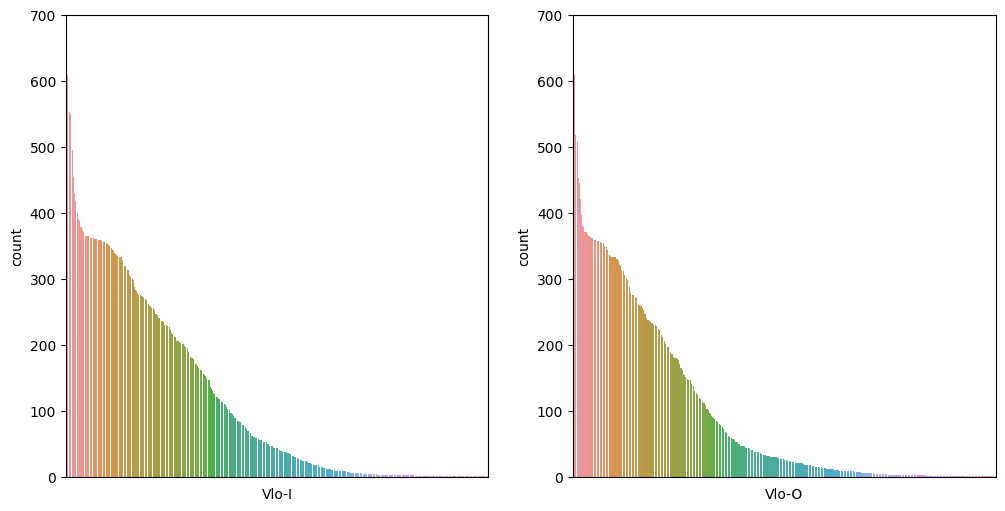

In [22]:
paired_counplot('Vlo-I', 'Vlo-O', df, ylim=[0, 700], showx_ticks=False)

En efecto existen diferencias, apreciables en las colas de los gráficos. En este caso, los códigos de vuelo se diferencian entre lo programado y lo operado. El gráfico de `Vlo-I` concentra más área hacia la derecha, mientras que el `Vlo-O` posee una cola levemente más larga. Esto se debe a que la variable `Vlo-O` tiene un rango mayor, es decir, hay más códigos de vuelos operados que programados. Esto puede ser un signo de lo que sucede con los atrasos, en principio, una posible relación causal podría revelar que la reprogramación de vuelos implica cambios de códigos, lo que es consistente con la experiencia.

/tmp/ipykernel_8966/2190682927.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plotn)


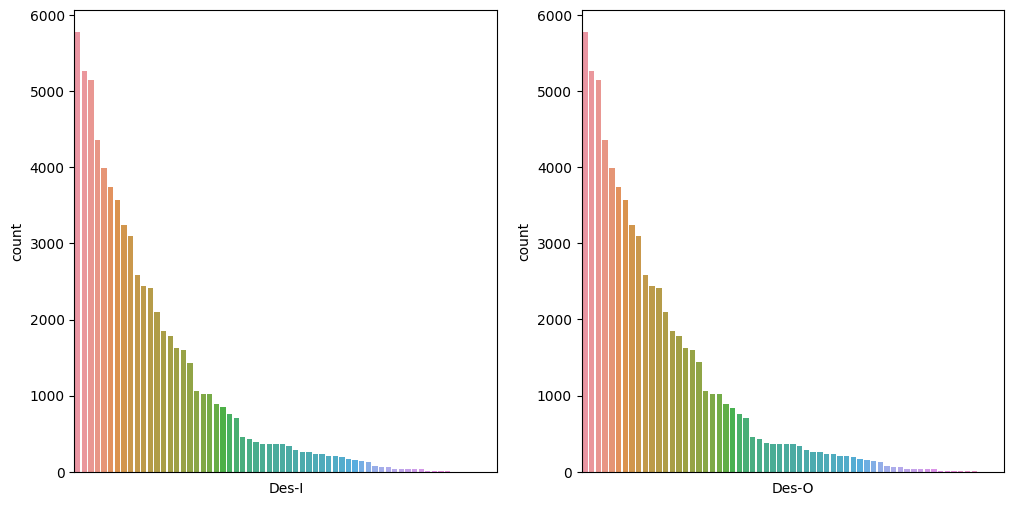

In [23]:
paired_counplot('Des-I', 'Des-O', df, showx_ticks=False)

Los gráficos de los códigos de destino no presentan una diferencia apreciable al ojo. Para observar diferencias tendríamos que aplicar otras técnicas, pero bastaría decir que de aquí es poco lo que se puede extraer. Es posible que esta variable no aporte información al cálculo del retraso, lo que también sería consistente con la experiencia. Queda como un posible candidato de eliminación de la matriz de características para que no genere ruidos a la hora de la inferencia.

/tmp/ipykernel_8966/2190682927.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plotn)


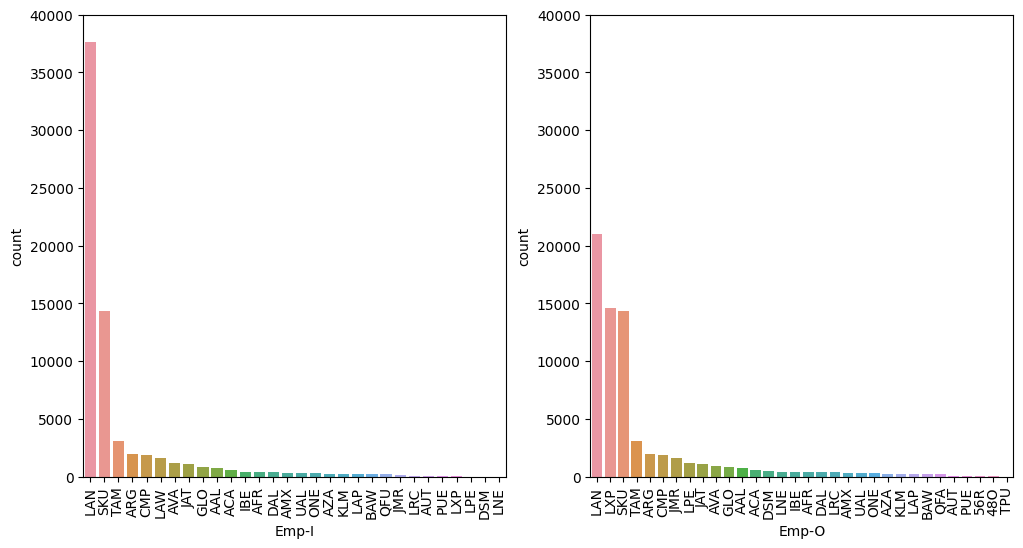

In [24]:
paired_counplot('Emp-I', 'Emp-O', df, ylim=[0, 40000])

Por otro lado la variación de los códigos de las aerolíneas sí que son visibles e importantes. El principal actor `LAN` muestra cambios importantes en reducción de vuelos programados con respecto a los operados. Por otro lado, `TAM`, ve un importante incremento en estos últimos, dejando claro que toma la responsabilidad de operar los códigos de `LAN`. Esto no es sorprendente debido a la fusión de `LATAM`, pero sí es una tendencia importante en este gráfico ya que los códigos de las otras aerolíneas permanecen básicamente invariantes.

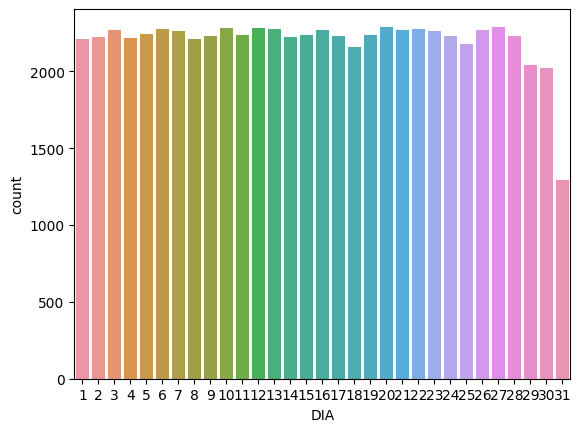

In [25]:
sns.countplot(x='DIA', data=df)
plt.show()

Los códigos de los días del mes presentan una ligera variación diaria, con una relevante caída en torno al fin de mes. Obviamente el día 31 contaría como un outlier para este análisis pues solo la mitad de los meses del año cuentan con esta numeración. Fuera de eso existe una leve tendencia a la baja en los últimos dos días de cada mes.

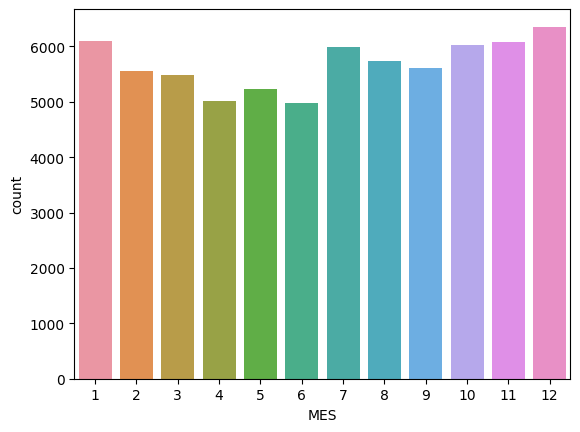

In [26]:
sns.countplot(x='MES', data=df)
plt.show()

La estadística mensual sugiere una variación estacional apreciable. Es posible suponer que existen periodos de alta y baja demanda, lo que es coincidente con los periodos vacacionales nacionales. En principio se pueden hacer análsis cruzando variables de mes del año versus si el vuelo es nacional o internacional, pues tal vez exista cierta compensación entre vuelos internacionales y nacionales con respecto a las estaciones. El análisis no se extiende pues no es el objetivo del desafío, además, algunos modelos de inferencia pueden establacer por sí solos estas relaciones.

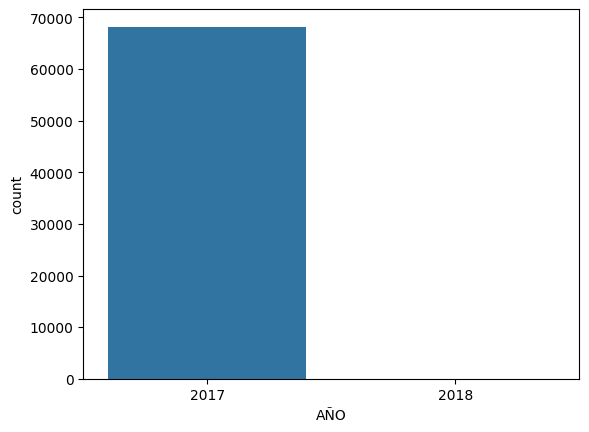

In [27]:
sns.countplot(x='AÑO', data=df)
plt.show()

La falta de información de diferentes años limita la capacidad de generalización de este análisis. No es posible determinar de una forma estadísticamente correcta la periodicidad, pues solo se tienen los datos de un año. No obstante, si relajo un poco esta restricción, todavía se puede realizar un desafío bastante productivo. Si bien los datos no pueden respaldar las conclusiones de una manera rigurosa, la información obtenida sigue siendo muy útil en una construcción futura.

In [28]:
df['AÑO'].value_counts()

2017    68203
2018        2
Name: AÑO, dtype: int64

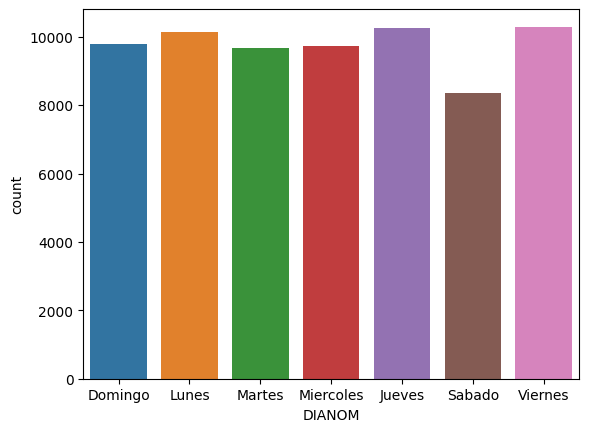

In [29]:
sns.countplot(x='DIANOM', data=df)
plt.show()

Los días sábado cae fuertemente la cantidad de vuelos. Esto es consistente con la subida de precios que normalmente muestran las aerolíneas para tales días. Es, por otro lado, inconsistente con respecto a la facilidad de oportunidad que tiene la gente para viajar en tales días. Es posible que se esté observando un efecto conjunto de la oferta de precios y la respuesta de los clientes. Tal vez, la demanda es bastante inelástica es estos días y la caída no es muy fuerte, o tal vez la estrategia esté dirigida a potenciar el uso de los recursos en los otros días. Sin un acceso a datos tarifarios no es posible realizar un análisis de mercadeo adecuado para explicar esto.

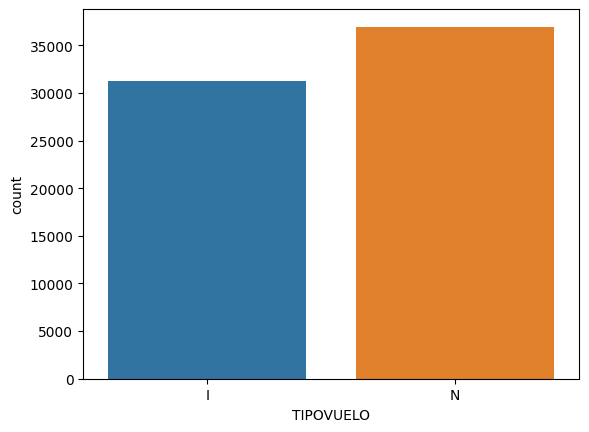

In [30]:
sns.countplot(x='TIPOVUELO', data=df)
plt.show()

La cantidad de vuelos nacionales que este aeropuerto opera sigue siendo muy relevante para el total de su capacidad anual. Si bien estos destinos son bastante más baratos, siguen siendo un importante componente dentro de las actividades de algunas aerolíneas. 

### **¿Qué te llama la atención o cuál es tu conclusión sobre esto?**

El manejo de vuelos en el aeropuerto parece mostrar una estrategia de reducción de variabilidad y mantención de un flujo constante. Me da la impresión de que esto ayuda a no sobrecargar los insumos y al personal, pero por sobretodo a reducir los tiempos muertos de los activos cuando estos no están en uso, probablemente, la misma pista de aterrizaje. El sistema está ordenado para que todas las aerolíneas se coordinen para maximizar el uso de este activo.

Junto a esto también cabe mencionar la gran presencia de los más grandes actores del mercado `LATAM` y `SKY` que imponen presencia sobre el set de datos.

## Preprocesamiento II

### **Generación de columnas adicionales**

**temporada_alta**

Se agrega una columna indicadora del valor de temporada según las especificaciones. Tomará el valor `ALTO` durante el periodo de alta demanda y el de `BAJO` si no. Se le idenfiticará con la columna `temporada_alta`.

In [31]:
def dda(timestamp):
    #Podría haber eliminado los datos del 2018, pero estoy tratando de hacer que esta función sea genérica.
    temp = 'BAJO'
    date = dt.datetime.strptime(str(timestamp), '%Y-%m-%d %H:%M:%S')
    t1 = dt.datetime.strptime(f'{date.year}-12-15', '%Y-%m-%d') #15-Dic
    t2 = dt.datetime.strptime(f'{date.year}-03-03', '%Y-%m-%d') #3-Mar
    t3 = dt.datetime.strptime(f'{date.year}-07-15', '%Y-%m-%d') #15-Jul
    t4 = dt.datetime.strptime(f'{date.year}-07-31', '%Y-%m-%d') #31-Jul
    t5 = dt.datetime.strptime(f'{date.year}-09-11', '%Y-%m-%d') #11-Sep
    t6 = dt.datetime.strptime(f'{date.year}-09-30', '%Y-%m-%d') #30-Sep
    
    if t1 < date or date < t2:
        temp = 'ALTO'
    if t3 < date and date < t4:
        temp = 'ALTO'
    if t5 < date and date < t6:
        temp = 'ALTO'
    
    return temp
    

In [32]:
df['temporada_alta'] = df['Fecha-I'].apply(dda)

**dif_min**

Se agrega una columna que indica la diferencia de minutos entre `Fecha-O`y `Fecha-I`.

In [33]:
df['dif_min'] = pd.to_datetime(df['Fecha-O']) - pd.to_datetime(df['Fecha-I'])
df['dif_min'] = df['dif_min'].apply(lambda x: x.total_seconds() / 60)

**atraso_15**

Se agrega una columna que indica si hay un atraso de 15 minutos en el vuelo o no. 

In [34]:
threshold = 15
df['atraso_15']  = df['dif_min'].apply(lambda x: 1 if x > threshold else 0)

**periodo_dia**

Se agrega una columna que indica el momento del día como un valor categórico. Se utiliza el valor de `MAÑANA` si la hora corresponde a algún momento entre las 5:00 y las 11:59, `TARDE` con un periodo entre las 12:00 y las 18:59, y `NOCHE` para el periodo entre las 19:00 y las 4:59.

In [35]:
def periodo(timestamp):
    momento = 'NOCHE'
    date = dt.datetime.strptime(str(timestamp), '%Y-%m-%d %H:%M:%S')
    hour = date.hour + date.minute / 60
    if 5 <= hour and hour < 12:
        momento = 'MAÑANA'
    if 12 <= hour and hour < 19:
        momento = 'TARDE'
        
    return momento

In [36]:
df['periodo_dia'] = df['Fecha-I'].apply(periodo)

In [37]:
df.head()

,index,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,temporada_alta,dif_min,atraso_15,periodo_dia
0,0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,2017,Domingo,I,ALTO,3.0,0,NOCHE
1,1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,2017,Lunes,I,ALTO,9.0,0,NOCHE
2,2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,2017,Martes,I,ALTO,9.0,0,NOCHE
3,3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,2017,Miercoles,I,ALTO,3.0,0,NOCHE
4,4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,2017,Jueves,I,ALTO,-2.0,0,NOCHE


In [38]:
df.drop('index', inplace=True, axis=1)

### **Genera las columnas adicionales y expórtalas a un archivo synthetic_features.csv**

Por temas de formato es probable que a la hora de la lectura del archivo cambien los valores de algunas columnas de tipo de dato, en especial con las series `Vlo-I`y `Vlo-O`. Para este problema es aconsejable utilizar un formato de `parquet` 

In [39]:
df[['temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia']].to_csv("synthetic_features.csv", sep=",", index=False)

## Análisis II

Los retrasos son asimétricos entre los orígeneres y los destinos. Esto puede tener que ver con el tema de las escalas.

### **¿Cómo se compone la tasa de atraso?**

Debido a que los valores operados terminan siendo variables afectadas por procesos aleatorios (retrasos), tanto para un análisis como para una inferencia es conveniente refererir las tasas de atraso con respecto a los valores programados. Esto sí resulta útil para poder construir planes con la información del análisis, como para poder comenzar a identificar las estrategias de entrenamiento para los modelos de inferencia.

Además, el desafío no especifíca directamente qué se entiende por tasa de atraso: si es la frecuencia de vuelos que se atrasan (traducible estadísticamente más tarde a probabilidad por los modelos) o si es la cantidad de minutos que se atrasan (como problema de regresión más tarde). Como ambas variables son útiles para una plan de atrasos graficaré ambas, e iré analizando en paralelo en base a la conveniencia. Por lo mismo, no es lo mismo atrasarse constantemente 5 minutos que 15. Por otro lado, por mucho que los atrasos sean escasos tampoco es lo mismo que unos pocos de ellos sean catastróficos, o ya cercanos a la hora. Ambas columnas aportan valiosa información en estos casos para manejar diferentes contingencias.

Por razones de comunicación denominaré a las tasas que provienen de la variable binaria `atraso_15` como tasas "frecuenciales", y a las otras, las que proceden de la variable `df_min` como "absolutas". 

In [41]:
def paired_barplot(cat, x1, x2, data, ylim=None, showx_ticks=True):
    """
    Cat: es la categoría de análisis
    x1: es la serie numérica n°1 de atraso -> atraso en 15 minutos típicamente
    x2: es la serie numérica n°2 de atraso -> minutos de atraso
    """
    
    sx1 = df.groupby(cat)[x1].mean() #Serie de promedios de la serien numérica 1 sobre la variable categórica
    sx2 = df.groupby(cat)[x2].mean() #Serie de promedios de la serien numérica 2 sobre la variable categórica
    sx3 = df.groupby(cat)[x1].std() #Desviación estándar
    sx4 = df.groupby(cat)[x2].std()
    sx1 = sx1.reset_index().sort_values(by=cat) #Upcasting to dataframe
    sx2 = sx2.reset_index().sort_values(by=cat)
    sx3 = sx3.reset_index().sort_values(by=cat)
    sx4 = sx4.reset_index().sort_values(by=cat)
    
    new_data = sx1
    new_data[x2] = sx2[x2]
    new_data[f'std_{x1}'] = sx3[x1]
    new_data[f'std_{x2}'] = sx4[x2]
    
    fig, ax = plt.subplots(figsize=(12, 6))

    axes  = [x1, x2]
    splot = [211, 212]
    for axis, plotn in zip(axes, splot):    
        plt.subplot(plotn)
        p = sns.barplot(x=cat, y=axis, data=new_data)
        p.errorbar(y=new_data[axis], 
           x=range(len(new_data)), 
           yerr=new_data[f'std_{axis}'], 
           fmt='none',
           linewidth=1, c='k')
        plt.xticks(rotation = 90)
        frame1 = plt.gca()
        if not showx_ticks:
            frame1.axes.get_xaxis().set_ticks([])
        if ylim is not None:
            plt.ylim(ylim)
    
    plt.show()

Al observarse el valor promedio es posible que se pierda la fuerza estadística que poseean las categorías con más repeticiones. Para esto mismo se ha incluído la desviación estándar en los gráficos. Los siguientes análisis están sujetos a los valores de las medias, y deben ser creíbles en cuanto a menor sea el valor de la desviación estándar. Si ésta es alto se reduce la credibilidad de lo analizado.

#### **Por destino**

/tmp/ipykernel_8966/2610170467.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plotn)


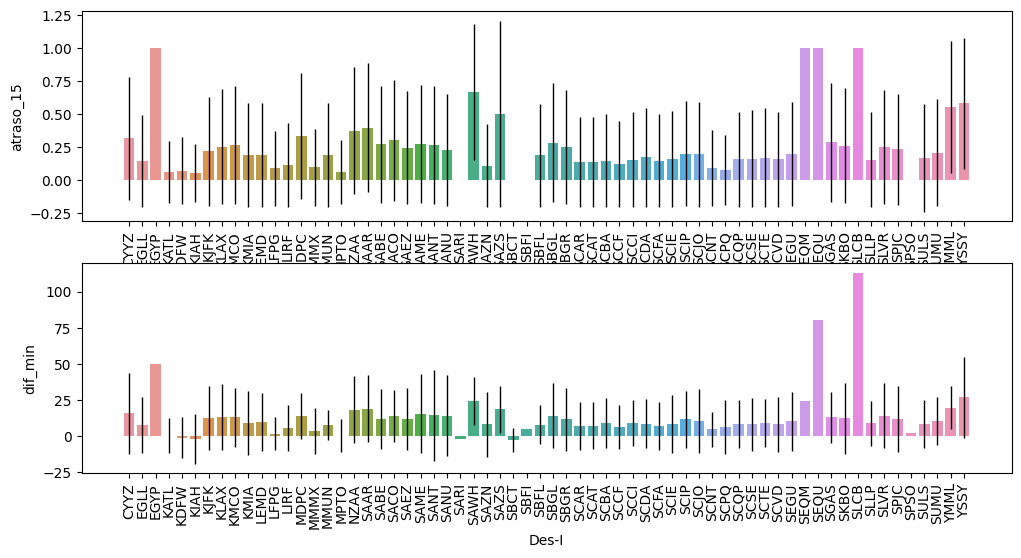

In [42]:
paired_barplot('Des-I', 'atraso_15', 'dif_min', df)

En cuanto a lo que el destino tiene que aportar como covariable estática la tasa de atraso frecuencial es relativamente univorme en torno a rangos de 0.15 y 0.3. Fuera de esto, existen importantes outliers o valores atípicos para cuatro destinos con un 100% de retraso, y otros 4 destinos con tasas por sobre el 0.5. 

En el caso de las tasas absolutas, los retrasos tienden a ser más uniformes, pero con importante presencia de 3 de los 8 outliers mencionados anteriormente. Tales destinos ciertamente deben provocar problemas o luces a las aerolíneas que los operan. Es posible que tal información aparezca como una variable dependiente. 

Ciertamente el destino es una variable de interés para realizar inferencias como parte del vector de características, en especial si el set de datos solo posee valores locales.

#### **Por aerolínea**

/tmp/ipykernel_8966/2610170467.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plotn)


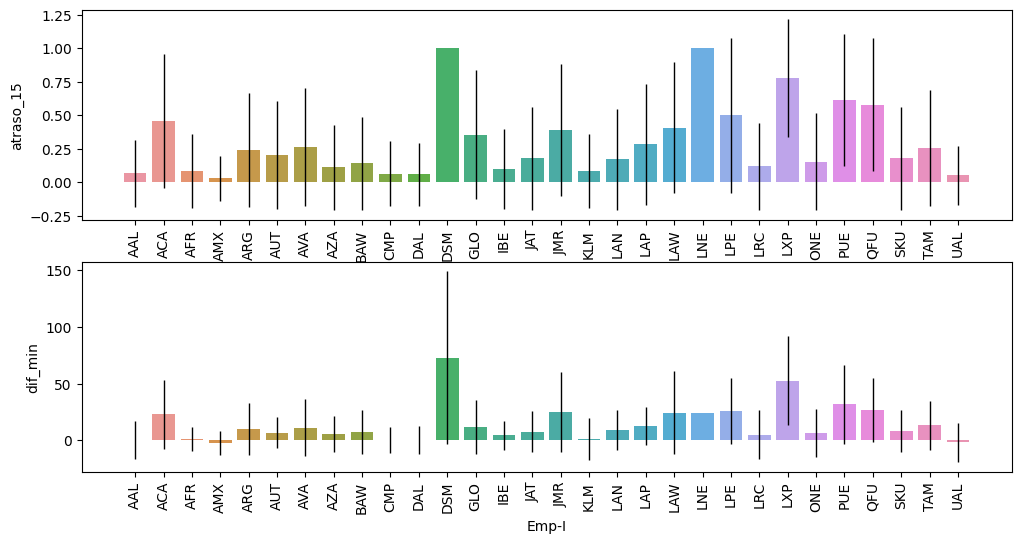

In [43]:
paired_barplot('Emp-I', 'atraso_15', 'dif_min', df)

La variabilidad de las medias de las tasas frecuenciales por aerolínea es aún mayor que por destino. Nuevamente aparecen varios valores atípicos. Llama la atención la baja media en la tasa de atraso frecuencial para los actores relevantes del aeropuerto `LATAM` y `SKY`. No solo su media es baja, sino su desviación estándar también lo es (comparativamente).

Las tasas de atraso absolutas se encuentran bien comportadas en su distribución por aerolínea, salvo casos puntuales.

En términos de predictibilidad, debido a la baja variación comparativa entre las medias se esta variable tiene menor potencia de inferencia que la del destino de vuelo. No obstante, al mirar más abajo, no sería prudente eliminarlo ya que algunas de las siguientes variables son menos informativas.

#### **Por mes del año**

/tmp/ipykernel_8966/2610170467.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plotn)


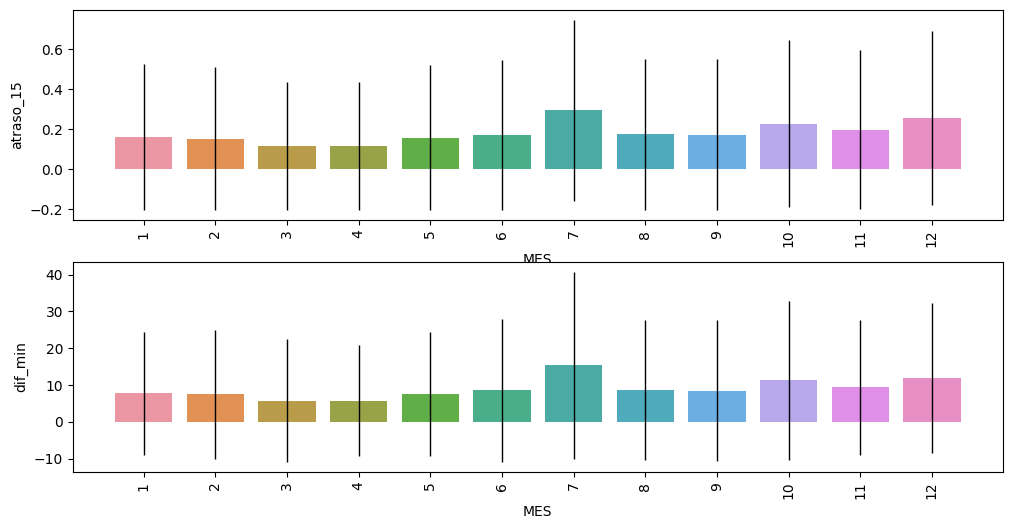

In [44]:
paired_barplot('MES', 'atraso_15', 'dif_min', df)

Las tendencias entre las tasas frecuenciales y absolutas con casi idénticas por lo que su comportamiento puede ser analizado en conjunto. En ambos casos existe una relativa tendencia a la estacionalidad mensual. Cosa que podría ser demostrable a través de un análisis de estacionalidad con librerías como `statsmodels` y datos que superen al año. Este es un canditato informativo de los comportamientos de atrasos.

#### **Por día de la semana**

/tmp/ipykernel_8966/2610170467.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plotn)


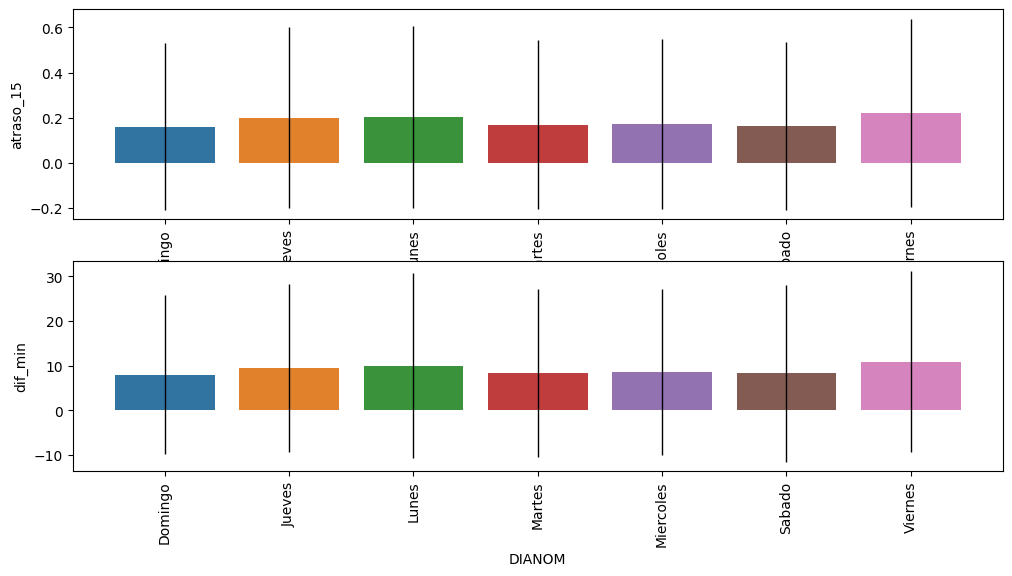

In [45]:
paired_barplot('DIANOM', 'atraso_15', 'dif_min', df)

De la misma manera que sucede con la periodicidad mensual esta variable es un candidato interesante para un análisis de estacionalidad. A diferencia del valor anterior, la frecuencia de muestreo y la cantidad de datos sí lo hacen posible en este caso. No obstante dicho eso, este análisis es más superficial por los alcances del desafío.

Dicho todo esto, al parecer esta también es una variable que muestra cierto poder de inferencia. Por sí sola puede explicar poco, pero se espera que, al ser una componente periódica sea un aporte y no se debería sacar de la matriz de características. Aunque no se descarta el hacerlo, el aporte informativo es el menor observado hasta la fecha.

#### **Por temporada**

/tmp/ipykernel_8966/2610170467.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plotn)


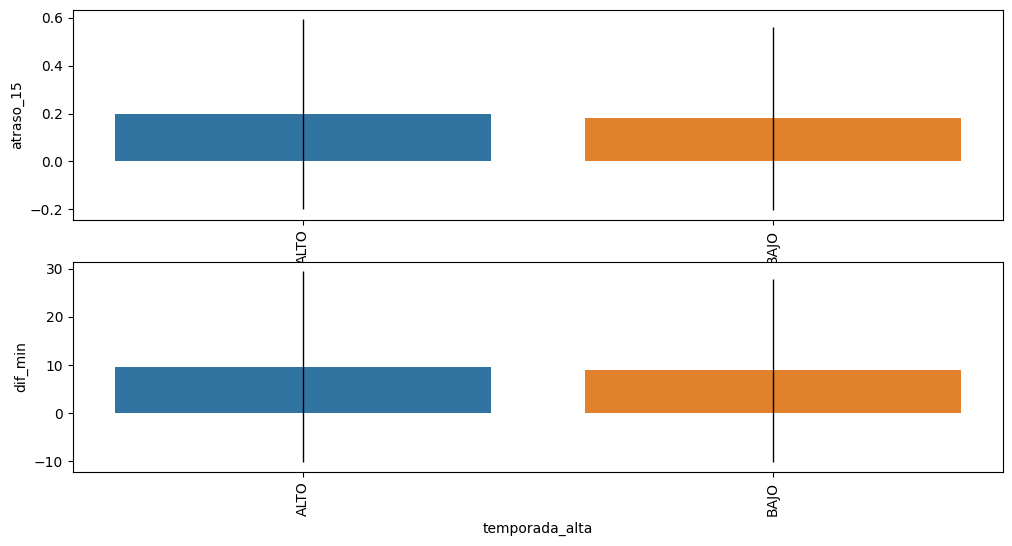

In [46]:
paired_barplot('temporada_alta', 'atraso_15', 'dif_min', df)

Contrario a lo que podría decir la intuición la demanda no parece ser un candidato eficaz para poder predecir el retraso. Estos valores parecen ser casi constantes a lo largo de los periodos observados para su cálculo. Tal vez los aeropuertos cuentan con un plan de acción que es bastante eficaz para mitigar este efecto.

#### **Por tipo de vuelo**

/tmp/ipykernel_8966/2610170467.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plotn)


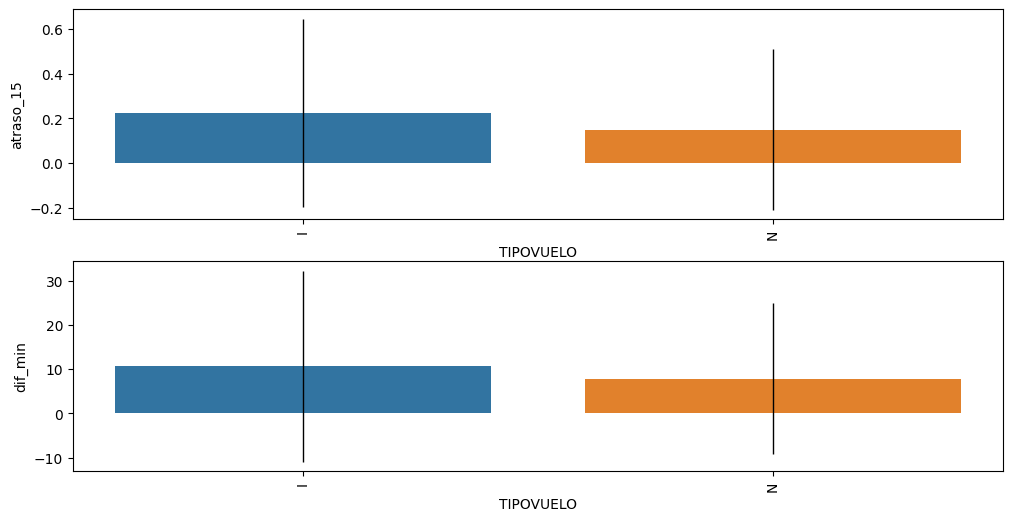

In [47]:
paired_barplot('TIPOVUELO', 'atraso_15', 'dif_min', df)

El tipo de vuelo sí es un claro diferenciador de la cantidad de retrasos que tienen los vuelos, y es que los vuelos internacionales presentan en mucha más frecuencia y tiempo promedio este comportamiento. 

#### **Por periodo del día**

Esto no era pedido, pero me parece relevante incluirlo, en especial si tiene algún significado

/tmp/ipykernel_8966/2610170467.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plotn)


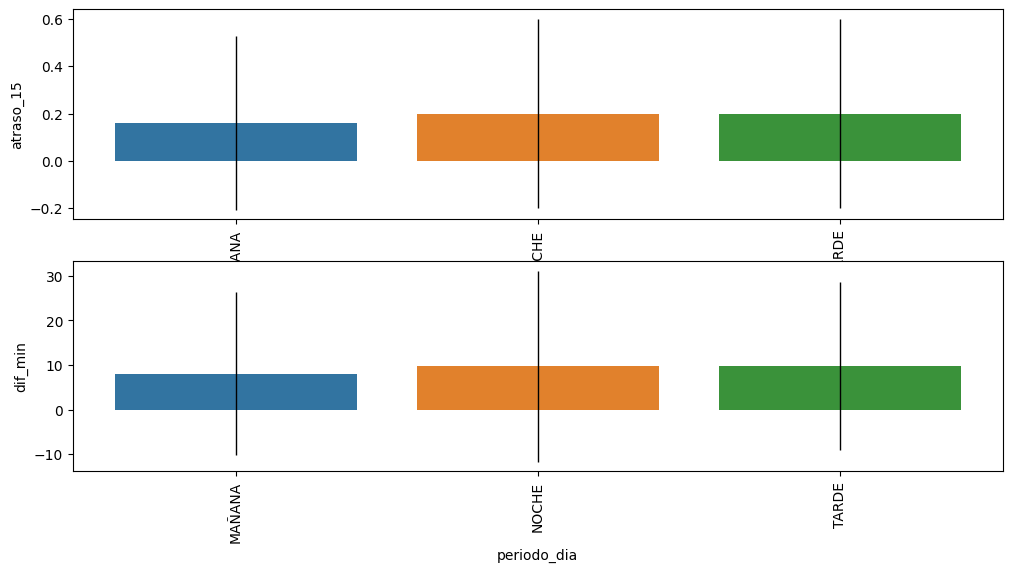

In [48]:
paired_barplot('periodo_dia', 'atraso_15', 'dif_min', df)

Existe una marcada diferencia entre las tasas frecuenciales y absolutas de atraso en los vuelos si estos suceden por la mañana o no. Esto puede jugar un papel relevante en la predicción, pero también en la compensación, debido a que pueden aparecer costos mayores en los periodos tardíos por la necesidad entrante de hotelería en algunos casos. 

### **¿Qué variables esperarías que influyeran más en predecir retrasos?**

Desde un punto de vista de la teoría de la información, las variables más informativas son aquellas que poseen más entropía de Shannon. A simple vista, aquellas variables con mayor tasa de variabilidad de la media son el destino y la aerolinea que opera el vuelo. 

## Entrenamiento de modelos de inferencia

### Agregando características adicionales

En general, se nota que se trata de un set de datos con bastantes variabilidades, por lo que los modelos de inferencia podrían llegar a presentar errores. En situaciones ideales se buscarían modelos que sean capaces de separar con alta capacidad los clústeres generados en los espacios de hipótesis. Debido al tiempo se trabajará con lo que se tiene. Es decir, se espera que el modelo no sea de muy alta precisión.

Para atacar un poco este punto sería mejor contar con más datos, o datos de más calidad. Una variable de posible interés a observar sería la congestión de la pista. Es decir, la cola de aeronaves en tierra esperando despegar, y la "cola virtual" de tráfico aéreo para aterrizar. Ninguna de estas variables está disponible, pero existe la posibilidad de crear un estimador para la primera. Debido a que se conocen los vuelos programados es posible establecer un indicador de retraso de vuelo saliente. Lamentablemente no se posee la misma información con respecto a los destinos pues el set de datos solo abarca un aeropuerto. No obstante esta información es un apoyo importante de 

Por otro lado, también es posible analizar con el set de datos la probabilidad compuesta de que un vuelo se atrase debido a que otro ya se atrasó. Tal inferencia sería propia de un modelo recursivo, y sería mejor tratado por una RNN o una LSTM (probablemente no hay suficientes datos para un transformer). Sin embargo me gustaría apoyar a algún modelo de machine learning clásico con dichos datos, pues tienen más capacidad de explicabilidad. 

Dentro de lo que es inferencia esto sería equivalente a hacer trampas, pues se trata de un valor a posteriori. La forma correcta de hacelo no sería con el valor a posteriori, sino calculando recursivamente con una predicción anterior. Si bien esto es posible, no quiero complicar el modelo clásico, sino simplemente aprovechar la capacidad de explicabilidad. Por lo que ese ejercicio quedará más en un campo teórico (usaré el valor a posteriori por simplicidad). Con esto quiero decir que, las verdaderas y más precisas predicciones las realizaré utilizando modelos neuronales en lo posible (sin posteriori), pero intentaré avanzar un modelo clásico (con valores posteriori, sin recursividad) con una capacidad explicativa mayor si es que la presición de inferencia es lo suficientemente alta.

In [3]:
def slide_tail(name, timew, data, xin='Fecha-I', timestop=60):
    data[name] = np.zeros(len(data))
    data_sorted = data.sort_values(by=xin).reset_index().copy()
    tail = np.zeros(len(data))
    for ids in data_sorted.index: #Hago la búsqueda en el set de datos ordenado
        currdate = data_sorted[xin][ids] #Dado un vuelo y su posición programada
        idx = data_sorted['index'][ids]
        intail = 0
        for i in range(ids-1, 0, -1): #Recorro el índice hacia atrás
            if currdate - data_sorted[xin][i] < dt.timedelta(minutes=timew):
                intail += 1 #Si tengo un vuelo cercano en el tiempo lo agrego a mi "cola"
            if currdate - data_sorted[xin][i] > dt.timedelta(minutes=timestop):
                break #No quiero irme muy atrás en el tiempo, hago una cierta suposición de orden temporal del set de datos
        tail[idx] = intail
    data[name] = tail

In [4]:
slide_tail('cola_04', 4, df)
slide_tail('cola_08', 8, df)
slide_tail('cola_12', 12, df)

In [162]:
df.head()

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,temporada_alta,dif_min,atraso_15,periodo_dia,cola_04,cola_08,cola_12
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,2017,Domingo,I,ALTO,3.0,0,NOCHE,0.0,0.0,0.0
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,2017,Lunes,I,ALTO,9.0,0,NOCHE,0.0,1.0,1.0
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,2017,Martes,I,ALTO,9.0,0,NOCHE,0.0,0.0,0.0
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,2017,Miercoles,I,ALTO,3.0,0,NOCHE,0.0,0.0,0.0
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,2017,Jueves,I,ALTO,-2.0,0,NOCHE,0.0,0.0,0.0


In [163]:
df.to_parquet('df.parquet', engine='fastparquet')

### Matriz de características

El atraso se puede contabilizar de varias maneras. Como mínimo, el desafío pide medir la probabilidad de retraso, pero otras métricas también pueden aportar información útil, como los tiempos de retraso (que en principio servirían para establecer tasas de pago de compensaciones). Se establecerán estas dos variables objetivo para este problema, por lo tanto. 

El problema de predicción de probabilidad puede tomarse como uno de clasificación por ciertos modelos (neuronal y bayesiano), por lo que es de interés el uso de métricas como presicion, recall, F1 y accuracy (por temas de tiempo se usó solo esta última). El problema de predecir los tiempos de retraso es de regresión, por lo que querríamos mirar métricas como MSE o MAE, dependiendo de la presencia de outliers en el set de datos. En este caso se optó por MAE, pues el set de datos es ruidoso, y los outliers podrían perturbar los resultados de métricas como MSE o RMSE. 

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#df = pd.read_csv('provisorio.csv')
df = pd.read_parquet('df.parquet', engine='fastparquet')

In [ ]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn.git --quiet

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_absolute_error

In [3]:
df.head()

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,temporada_alta,dif_min,atraso_15,periodo_dia,cola_04,cola_08,cola_12
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,2017,Domingo,I,ALTO,3.0,0,NOCHE,0.0,0.0,0.0
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,2017,Lunes,I,ALTO,9.0,0,NOCHE,0.0,1.0,1.0
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,2017,Martes,I,ALTO,9.0,0,NOCHE,0.0,0.0,0.0
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,2017,Miercoles,I,ALTO,3.0,0,NOCHE,0.0,0.0,0.0
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,2017,Jueves,I,ALTO,-2.0,0,NOCHE,0.0,0.0,0.0


Este set de datos tiene muchas variables categóricas sin orden, por lo que se codificarán como onehot. Las columnas numéricas serán escaladas con un robustscaler por los posibles ruidos de los datos, pero más que nada por un desconocimiento del sistema. No parece correcto un escalamiento estadístico gaussiano debido a los resultados del análisis, y el escalamiento MinMan podría entrar en juego, pero optaré por la estrategia comentada.

In [4]:
targets = ['atraso_15', 'dif_min'] #El orden es importante (ver modelo más abajo)
catcols = ['Vlo-I', 'Des-I', 'Emp-I', 'Vlo-O', 'Des-O', 'Emp-O', 'DIANOM', 'TIPOVUELO', 'temporada_alta', 'periodo_dia']
numcols = ['MES', 'cola_04', 'cola_08', 'cola_12']

In [5]:
ohe = preprocessing.OneHotEncoder()
rse = preprocessing.RobustScaler() #Considerando que hay algunos outliers y el set de datos es algo ruidoso puede que este funcione mejor

categorical_data = ohe.fit_transform(df[catcols])
cat_array = categorical_data.toarray() #Este método expande una matriz sparse de scipy, hay que tener cuidado con la memoria en ciertos casos
num_array = rse.fit_transform(df[numcols])

y = df[targets].to_numpy()
X = np.concatenate((cat_array, num_array), axis=1)

X_train, X_2split, y_train, y_2split = train_test_split(X, y, test_size=0.2) #No dispongo de demasiados datos para un modelo de deeplearning por lo que estoy tratando de cuidar el entrenamiento
X_valid, X_test, y_valid, y_test = train_test_split(X_2split, y_2split, test_size=0.5) #El resto lo divido entre sets de entrenamiento y validación

lenset, nfeats = X.shape


### Análisis de componentes principales

Al codificar OneHot existen muchos datos redundantes, pues la codificación facilita eso. Es necesario eliminar variables dependientes, para lo que se vuelve muy útil el análisis de componentes principales.

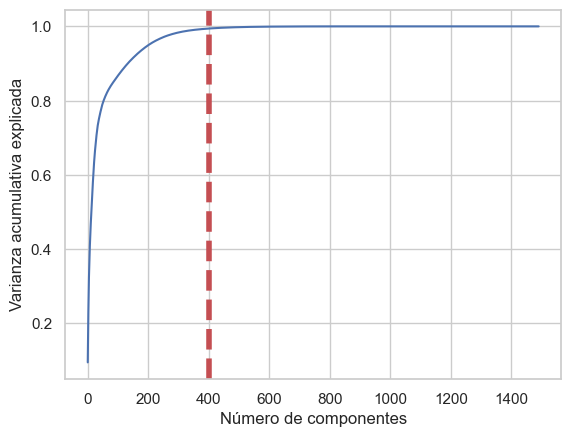

None

In [6]:
pca_test = PCA(n_components=nfeats)
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulativa explicada')
nfeats = 400 #Nueva cantidad de características
plt.axvline(linewidth=4, color='r', linestyle = '--', x=nfeats, ymin=0, ymax=1)
display(plt.show())

In [7]:
pca = PCA(n_components=nfeats)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

De no usar esta herramienta la cantidad de parámetros del modelo sería demasiado grande, y tendería al overfitting.

### Deeplearning

In [8]:
!nvidia-smi

Fri Jan 20 17:05:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8    N/A /  N/A |      4MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [98]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sys
from time import time
import datetime

In [10]:
class FlightsDataset(Dataset): #Clase dataset para cargar los datos como tensores de pytorch
    def __init__(self, X, y, device):
        self.X = X
        self.y = y
        self.length_dataset, _ = X.shape
        self.device = device
        
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx]).to(self.device)
        y = torch.tensor(self.y[idx]).to(self.device)
        
        return X.float(), y.float()

    def __len__(self):
        return self.length_dataset

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128
train_set = FlightsDataset(X_train_pca, y_train, device)
valid_set = FlightsDataset(X_valid_pca, y_valid, device)
test_set = FlightsDataset(X_test_pca, y_test, device)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [36]:
#Modelo
class Perceptron(torch.nn.Module):

    def __init__(self, layersizes, drops, device):
        super(Perceptron, self).__init__()

        l1, l2, l3, l4 = layersizes
        d1,d2 = drops
               
        self.sequent = nn.Sequential(
                          nn.Linear(nfeats, l1),
                          nn.ReLU(),
                          nn.Linear(l1, l2),
                          nn.ReLU(),
                          nn.BatchNorm1d(l2),
                          nn.Dropout(d1),
                          nn.Linear(l2, l3),
                          nn.ReLU(),
                          nn.BatchNorm1d(l3),
                          nn.Dropout(d2),
                          nn.Linear(l3, l4),
                          nn.ReLU(),
                          nn.BatchNorm1d(l4),
                          nn.Linear(l4, 2)
                          )
        
        self.softmax = nn.Softmax(dim=1)
        
        self.t1 = torch.tensor(np.array([[1, 0], [0, 0]])).to(device).float()
        self.t2 = torch.tensor(np.array([[0, 0], [0, 1]])).to(device).float()

    def forward(self, x):
        
        x = self.sequent(x)
        
        x1 = x @ self.t1 #Esta neurona es para predicción de atraso en vuelo
        x1 = self.softmax(x1)
        
        x2 = x @ self.t2 #Esta neurona es para regresión
        #La separación de las tareas me ayudará a utilizar el mismo set de pesos para ambos problemas, lo cual mejora también la convergencia en algunos casos
        
        return x1 + x2
    
layersizes = [32, 64, 32, 8]
dropouts_p = [0.4, 0.4]

model = Perceptron(layersizes, dropouts_p, device).to(device)

total_params = sum(
    param.numel() for param in model.parameters()
)
print(total_params)    

17514


Aquí me cuido especialmente de que la cantidad de parámetros de mi modelo no sea excesivamente alta considerando la cantidad de datos disponibles para el entrenamiento (~54k).

In [33]:
#Función de pérdida
cel = nn.CrossEntropyLoss()
mse = nn.MSELoss()

def lossfn(y_pred, y_true, alpha=0.5):
    t1 = torch.tensor(np.array([[1, 0], [0, 0]])).to(device).float()
    t2 = torch.tensor(np.array([[0, 0], [0, 1]])).to(device).float()
    
    atrasos_pred = y_pred @ t1
    atrasos_true = y_true @ t1
    
    dif_min_pred = y_pred @ t2
    dif_min_true = y_true @ t2
    
    z1 = cel(atrasos_pred, atrasos_true)
    z2 = mse(dif_min_pred, dif_min_true)
    
    return alpha * z1 + (1-alpha) * z2 #La función de pérdida tiene como hiperparámetro la ponderación del peso de la tarea a optimizar
    

In [96]:
#Función de entrenamiento y testeo
def epoch(model, loader, optimizer, criterion, confidence, train=True):
    if (train):
        model.train()
    else:
        model.eval()
        torch.no_grad()

    mean_loss = 0
    correct = 0
    t1 = torch.tensor(np.array([[1], [0]])).to(device).float()
    t2 = torch.tensor(np.array([[0], [1]])).to(device).float()

    Y_true_acc = []
    Y_pred_acc = []
    Y_true_mae = []
    Y_pred_mae = []

    for (data, labels) in loader:
        prediction = model(data)
        optimizer.zero_grad()
        loss = criterion(prediction, labels)
        if (train):                  
            loss.backward()
            optimizer.step()
        mean_loss += loss.item()
        
        yta = labels @ t1
        yta = list(yta.cpu().detach().numpy().flatten())
        ypa = prediction @ t1
        ypa = ypa.cpu().detach().numpy().flatten()
        ypa = list(np.ceil(ypa - confidence)) #El valor se convierte en 1 cuando se supera la confianza, es decir, cuando se predice un atraso
                                            #Cero si no

        ytm = labels @ t2
        ytm = list(ytm.cpu().detach().numpy().flatten())
        ypm = prediction @ t2
        ypm = list(ypm.cpu().detach().numpy().flatten())
        
        Y_true_acc += yta
        Y_pred_acc += ypa
        Y_true_mae += ytm
        Y_pred_mae += ypm

    epoch_loss = mean_loss/len(loader)
    # epoch_acc  = correct/len(loader)
    epoch_acc  = accuracy_score(Y_true_acc, Y_pred_acc)
    epoch_mae  = mean_absolute_error(Y_true_mae, Y_pred_mae)

    return epoch_loss, epoch_acc, epoch_mae

In [112]:
layersizes = [32, 64, 32, 8]
dropouts_p = [0.4, 0.4]

model = Perceptron(layersizes, dropouts_p, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

confidence = 0.95 #Se trata de predecir que un valor será un atraso cuando la probabilidad de atraso se vuelve de un 95%
                    #Se debe considerar como un parámetro de threshold o valor p dependiendo del análisis
nepochs = 30
t_loss, t_acc, v_loss, v_acc, t_mae, v_mae = [], [], [], [], [], []
start = time()

for ep in range(nepochs):
    train_loss, train_acc, train_mae = epoch(model, 
                                             train_loader, 
                                             optimizer, 
                                             lossfn, 
                                             confidence, 
                                             train=True)
    
    valid_loss, valid_acc, valid_mae = epoch(model, 
                                             valid_loader, 
                                             optimizer, 
                                             lossfn, 
                                             confidence, 
                                             train=False)
    t_loss.append(train_loss)
    t_acc.append(train_acc)
    v_loss.append(valid_loss)
    v_acc.append(valid_acc)
    t_mae.append(train_mae)
    v_mae.append(valid_mae)

    msj = "Training {:.2f}% complete. Training loss {:.5f}, validation loss {:.5f}. Training accuracy {:.2f}, validation accuracy {:.2f}. Training MAE {:.2f}, validation MAE {:.2f}"
    msj = msj.format((ep+1)/nepochs*100, train_loss, valid_loss, train_acc, valid_acc, train_mae, valid_mae)
    for i in range(len(msj)):
        sys.stdout.write('\r')
    sys.stdout.write(msj)

stop = time()
print(" ")
print("Training time = ", datetime.timedelta(seconds=int(stop-start)))

Training 100.00% complete. Training loss 72.88222, validation loss 88.07807. Training accuracy 0.81, validation accuracy 0.80. Training MAE 10.10, validation MAE 11.00 
Training time =  0:02:31


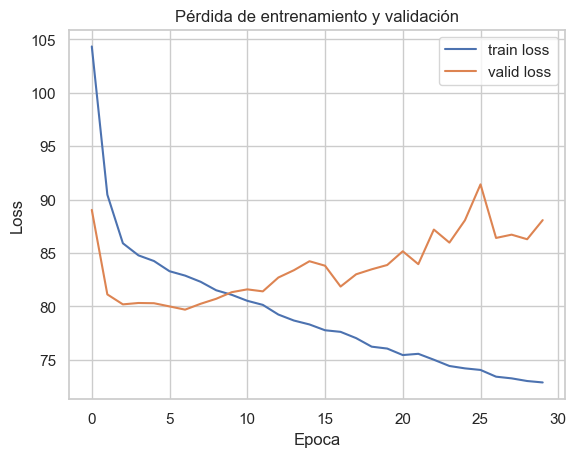

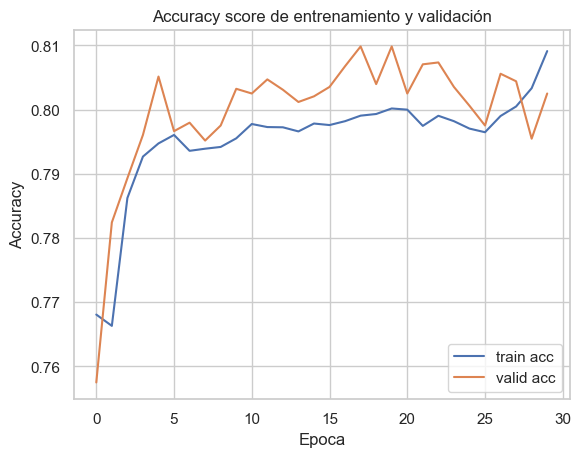

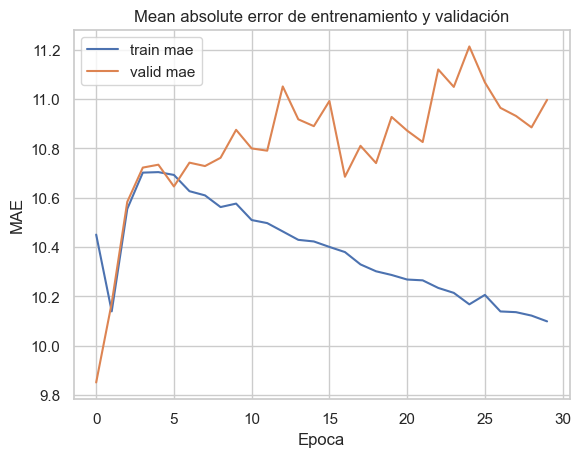

In [113]:
plt.plot(list(range(nepochs)), t_loss, label='train loss')
plt.plot(list(range(nepochs)), v_loss, label='valid loss')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(list(range(nepochs)), t_acc, label='train acc')
plt.plot(list(range(nepochs)), v_acc, label='valid acc')
plt.title('Accuracy score de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(list(range(nepochs)), t_mae, label='train mae')
plt.plot(list(range(nepochs)), v_mae, label='valid mae')
plt.title('Mean absolute error de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [114]:
test_loss, test_acc, test_mae = epoch(model, 
                                         test_loader, 
                                         optimizer, 
                                         lossfn, 
                                         confidence, 
                                         train=False)
print(f'Resultados del test: pérdida {test_loss:.5f}, presición {test_acc:.2f}, error absoluto medio {test_mae:.2f}')

Resultados del test: pérdida 81.89183, presición 0.81, error absoluto medio 10.64


### Machine learning

Tenía la intención de agregar modelos de machine learning clásico, SVM, Naive Bayes y/o Logistic tree, pero por cuestión de tiempo no alcancé. Traté de mostrar mi caballo de batalla que es el deep learning y apenas pude terminarlo, ni siquiera alcancé a hacer búsqueda de hiperparámetros.

## Evaluación del modelo

### **¿Qué performance tiene el modelo?**

Los resultados en testo son de una precisión del 81% en la predicción de atrasos, y un error absoluto medio de 10.6 minutos en el valor del atraso. La primera tarea, pedida en el enunciado del desafío se cumple con una precisión decente, pero la tarea secundaria propuesta es, a mi juicio, mal lograda. Es posible que se necesite de un modelo con una mejor representación del proceso para tal caso.

### **¿Qué métricas usaste para evaluar esta performace y porqué?**

Utilicé las métricas de `accuracy` para el problema de predicción de atrasos, y la de `MAE` para el problema de predicción del tiempo de atraso. 
El primer problema se resuelve mirando la predicción como un problema de clasificación. Al codificar cada muestra como 0 o 1 en cuanto al atraso, y dejar una neurona con función de activación SoftMax estoy condicionando al cálculo de una probabilidad de que la muestra sea clasificada como 0 o 1, que es exactamente lo que se me pide. Por lo mismo, para los problemas de clasificación la métrica de `accuracy` es de las más utilizadas. Debo decir, eso sí, que me habría gustado 
agregar `recall` y `F1` score, pero la extensión del desafío no me parece justificado en esta oportunidad.

Para el problema de regresión escogí `MAE` pues se trata de una métrica muy sólida para este tipo de problemas. Los errores, tanto grandes como pequeños, quedam medidos más o menos con el mismo peso, y el sistema no tiende a retener demasiada memoria. Otras métricas como `R^2` son aceptables, más no `MSE` o `RMSE` pues los outliers que aparecieron en el análisis indicaban que solo unos pocos datos más ruidosos serían ponderados con mucha fuerza.

### **¿Por qué elegiste este algoritmo en particular?**

Mi razón personal para el uso de deeplearning es que conozco bien esta técnica, y creo que puede llegar a ser muy útil con datos complejos. Además, la opción de paralelización y aceleración de hardware es un elemento que puede ser muy deseable en algunos casos.

Si bien es una técnica que sacrifica explicabilidad por precisión, para los requerimientos del desafío viene muy bien. Dentro de las explicaciones de la problemática entregadas en la entrevista, se presentó la necesidad de que este tipo de inferencias ayudasen a construir planes de compensación. Sobre lo conversado, no existía un requerimiento de explicabilidad y sí parecía ser importante la precisión.

Lamentablemente la ténica requiere de bastante trabajo. Por un lado fue bueno el disponer de suficiente tiempo en esta época, pero también habría querido hacer un mejor trabajo con la búsqueda de hiperparámetros. Aún así, estoy satisfecho con el resultado, lo que me confirma que, para las condiciones, fue una buena desición. De haber necesitado más velocidad o agilidad habría tenido que utilizar solamente el machine learning clásico. Que por cierto, sigue siendo muy útil.

### **¿Qué variables son las que más influyen en la predicción?**

Debido a la técnica que escogí, esta pregunta se vuelve incontestable. Con mayor razón después de la reducción hecha por PCA.

Sin embargo, la razón de haber volvado tiempo en el análisis inicial es justamente para tratar de sopesar estos problemas. Si bien no es una respuesta definitiva, las variables que probablemente más influyen en la predicción son el destino y la aerolínea que opera el vuelo.

### **¿Cómo podrías mejorar la performance?**

Sin duda sería ideal el gastar más tiempo en una búsqueda de hiperparámetros y/o un sistema benchmark con otras técnicas o modelos. Esto pues fue uno de los principales inconvenientes a la hora de la inferencia.

Sin embargo, la experiencia suele dictar que la mayor riquesa se encuentra en los mismos datos. Durante el análisis resultó más o menos claro que la fuerte localidad de los datos (el estar referidos a un único aeropuerto) es una debilidad del set. Obviamente el tener más datos sería interesante, pero más que aumentar en cuanto a muestras, sería un excelente complemento para mejorar la performance el conocer el estado de congestión de los vuelos en los aeropuertos externos. Esto impacta en los retrasos tanto de salida como de llegada a destino. En el primer caso, un vuelo atrasado externamente, encadenará en retrasos a los vuelos que usan a ese avión en el futuro. Por otro lado, resulta obvio que se pueden producir retrasos, también por congestión, en el aeropuesto de destino. Ambos datos son desconocidos. Es por esta razón que también traté de inferir un estadístico que representara eso de manera local. Pero se desconoce el verdadero impacto de dicha variable.